# <font color="red"> <font size="10px"> Load the required functions and classes </font>

In [1]:
# Essentials                         
import numpy
import pandas
import matplotlib.pyplot as plt


# Model related
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# Others
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.metrics import RootMeanSquaredError
from IPython.display import display_html             # To be able to display Pandas DataFrames side by side 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# <font color="red"> <font size="10px"> Import the dataset and observe </font>

In [2]:
dataset = pandas.read_csv("https://raw.githubusercontent.com/halil-durmaz/Datasets/main/irandata.csv")

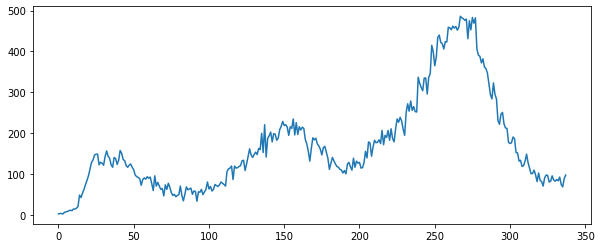

In [3]:
####################
# Quick observation
####################

fig, ax = plt.subplots(figsize=(10,4))     # Size of the figure

plt.plot(dataset)

- Seasonality

In [4]:
dataset = dataset.values                      # Pandas DataFrame ---> Numpy Array
dataset = dataset.astype('float32')           # int ---> float. To prepare the values for normalizing

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# <font color="red"> <font size="10px"> Set the seed </font>

- The purpose is to be able to reproduce the same results everytime

In [5]:
numpy.random.seed(555)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# <font color="red"> <font size="10px"> Normalizing </font>
- LSTM networks have sensitivity for the scales of the input variables.

In [6]:
normalizer = MinMaxScaler(feature_range=(0,1))     # Creation of the "Normalizer" model. Values will be scaled in the 0-1 range 

dataset = normalizer.fit_transform(dataset)        # Train the model + Transform the values

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# <font color="red"> <font size="10px"> Split into "Training set" & "Testing set" </font>

- In a Time-Series data, the order of the data matters. It is a sequential dataset. Therefore, assigning the observations in the dataset into both Training set and Testing set "randomly" is not reasonable. That is why, we will perform this operation by using the index values of the rows

In [7]:
training_upperboundary = int(len(dataset) * 0.8)                                  # First %80 of the observations will generate the Training set

training_set, testing_set = dataset[0:training_upperboundary, :], dataset[training_upperboundary:len(dataset), :]

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# <font color="red"> <font size="10px"> Split the 2 sets into "X" & "y" portions </font>

- An example schema to understand the upcoming operation:

![schema](https://cdn.imageupload.workers.dev/MORdYavD_screen.png)

<br>

- In order to make a prediction, we will get last 2 (time step) observation:
><u>Example 1:</u> In order to predict a, we will need 50 and 60<br>
><u>Example 2:</u> In order to predict b, we will need 60 and a

<br>

- If the value of `amount_timestep` variable is 3, `X_train` will have 3 columns<br>
However, `y_train` will always have 1 column


In [8]:
####################################################
# Create a function that will perform the operation
####################################################
def create_dataset(dataset, amount_timestep):
        X_data, y_data = [], []
        
        for i in range(len(dataset)-amount_timestep-1):
                  a = dataset[i:(i+amount_timestep), 0]
                  X_data.append(a)
                  y_data.append(dataset[i + amount_timestep, 0])
        
        return numpy.array(X_data), numpy.array(y_data)


########################
# Perform the operation
########################
amount_timestep = 2                                    # Define it here, since the value will be used later on as well

X_train, y_train = create_dataset(training_set, amount_timestep)
X_test, y_test   = create_dataset(testing_set, amount_timestep)

<br>
<br>

- Let's see `X_train` and `y_train` side by side

In [9]:
########################
# Create the DataFrames
########################
temporary_X_train = pandas.DataFrame(X_train)
temporary_y_train = pandas.DataFrame(y_train)


#######################
# Display side by side
#######################
temporary_X_train_style = temporary_X_train.head(7).style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("X_train")
temporary_y_train_style = temporary_y_train.head(7).style.set_table_attributes("style='display:inline'").set_caption("y_train")

display_html(temporary_X_train_style._repr_html_() + temporary_y_train_style._repr_html_(), 
             raw=True)

X_train 
 
 
   
 0 
 1 
 
 
 
 
 0 
 0.000000 
 0.002070 
 
 
 1 
 0.002070 
 0.002070 
 
 
 2 
 0.002070 
 0.000000 
 
 
 3 
 0.000000 
 0.008282 
 
 
 4 
 0.008282 
 0.010352 
 
 
 5 
 0.010352 
 0.012422 
 
 
 6 
 0.012422 
 0.016563 
 
 
 

 
 y_train 
 
 
   
 0 
 
 
 
 
 0 
 0.002070 
 
 
 1 
 0.000000 
 
 
 2 
 0.008282 
 
 
 3 
 0.010352 
 
 
 4 
 0.012422 
 
 
 5 
 0.016563 
 
 
 6 
 0.018634

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# <font color="red"> <font size="10px"> Reshape the input </font>

- Current dimensions of `X_train` and `X_test` is `[# of samples, Time steps]`. 

- However, since the LSTM network requires a 3 dimensional object, they will be reshaped

In [10]:
print(X_train.shape)
print(X_test.shape)

(267, 2)
(65, 2)


In [11]:
##########
# X_train
##########
X_train = numpy.reshape(X_train,                                         # This will be reshaped
                       (X_train.shape[0], 1, X_train.shape[1])           # into this shape
                       )
print(X_train.shape)


#########
# X_test
#########
X_test  = numpy.reshape(X_test,                                          # This will be reshaped
                       (X_test.shape[0], 1, X_test.shape[1])             # into this shape
                       )
print(X_test.shape)

(267, 1, 2)
(65, 1, 2)


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# <font color="red"> <font size="10px"> LSTM network (not optimized yet) </font>

## <font color="orange"> Designing the model </font>

In [12]:
model = Sequential()                                 # Create a Sequential model


#################
# Add the layers
#################
model.add(LSTM(100,                                   # This will create a hidden layer with 20 blocks
               activation="relu",                    # ReLU function, almost always performs much better than Sigmoid function
               input_shape=(1, amount_timestep)))       

model.add(Dense(1))                                  # 1 output block is required for this problem


##########
# Compile
##########
model.compile(loss='mean_squared_error', 
              optimizer="sgd",
              metrics=[RootMeanSquaredError()])      # To report the RMSE

<br>
<br>

## <font color="orange"> Training the model </font>

In [13]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs = 25, 
                    batch_size = 1,
                    verbose = 2)                    

Epoch 1/25
267/267 - 3s - loss: 0.0551 - root_mean_squared_error: 0.2348 - val_loss: 0.0716 - val_root_mean_squared_error: 0.2675 - 3s/epoch - 13ms/step
Epoch 2/25
267/267 - 1s - loss: 0.0413 - root_mean_squared_error: 0.2033 - val_loss: 0.0597 - val_root_mean_squared_error: 0.2444 - 1s/epoch - 5ms/step
Epoch 3/25
267/267 - 1s - loss: 0.0384 - root_mean_squared_error: 0.1959 - val_loss: 0.0576 - val_root_mean_squared_error: 0.2400 - 1s/epoch - 4ms/step
Epoch 4/25
267/267 - 1s - loss: 0.0351 - root_mean_squared_error: 0.1873 - val_loss: 0.0555 - val_root_mean_squared_error: 0.2355 - 1s/epoch - 5ms/step
Epoch 5/25
267/267 - 1s - loss: 0.0319 - root_mean_squared_error: 0.1785 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2115 - 1s/epoch - 5ms/step
Epoch 6/25
267/267 - 1s - loss: 0.0289 - root_mean_squared_error: 0.1701 - val_loss: 0.0402 - val_root_mean_squared_error: 0.2004 - 987ms/epoch - 4ms/step
Epoch 7/25
267/267 - 1s - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_loss:

<br>
<br>

## <font color="orange"> Overfitting & Underfitting analysis by plotting
 </font>

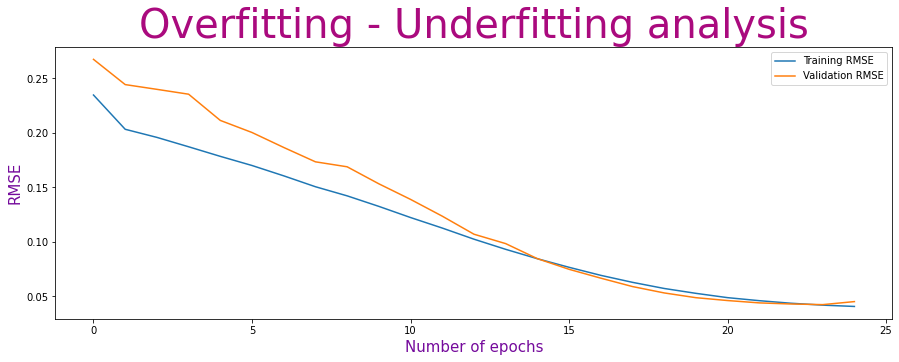

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))


plt.plot(history.history["root_mean_squared_error"],
         label="Training RMSE")

plt.plot(history.history["val_root_mean_squared_error"],
         label="Validation RMSE")


# Title + Axis Labels
plt.title("Overfitting - Underfitting analysis",
          fontsize=40,
          color="#AA0A7E")

plt.xlabel("Number of epochs",
           fontsize=15,
           color="#750B9C")

plt.ylabel("RMSE",
           fontsize=15,
           color="#750B9C")


plt.legend()

plt.show()

- There is no Overfitting problem

<br>

- When timestep was high, Val_RMS was high
- When batchsize was high, Val_RMS was high

<br>

- In order to spot the best hyperparameter values, Grid Search can be used


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# <font color="red"> <font size="10px"> Raw value transformation </font>


- Now, all of the variables below, has the normalized values. Therefore, we need to return them back to their raw values



In [15]:
dataset = normalizer.inverse_transform(dataset)
y_train = normalizer.inverse_transform([y_train])
y_test  = normalizer.inverse_transform([y_test])

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# <font color="red"> <font size="10px"> Future predictions </font>


<br>
<br>

## <font color="orange"> Example: 1st Forecast value
 </font>

In [16]:
input_for_prediction = numpy.array([89, 98])                                        # Use the last 2 input values

input_for_prediction = input_for_prediction.reshape((1, 1, amount_timestep))        # Reshape

first_forecastvalue = model.predict(input_for_prediction)                           # Make prediction
 
first_forecastvalue[0][0]                                                           # Forecast value

179.97632

<br>
<br>

## <font color="orange"> Forecasting the next Nth values </font>

In [17]:
predictions_list = []
input_list  = [89, 98]

for i in range (3):                                                                                   # Make 3 predictions
      input_list3 = numpy.array(input_list).reshape((1, 1, amount_timestep)).astype(numpy.float32)    # Crate NumPy array + Reshape + Turn to Float
      prediction = model.predict(input_list3)                                                         # Make prediction
      predictions_list.append(prediction[0][0])                                                       # Append prediction to the predictions list
      
      input_list.append(prediction[0][0])                                                             # Append prediction to
      input_list.pop(0)                                                                               # Remove the first element of the input_list

predictions_list

[179.97632, 262.98935, 420.28674]

<br>
<br>

## <font color="orange"> Visualize the future predictions along with the real data </font>

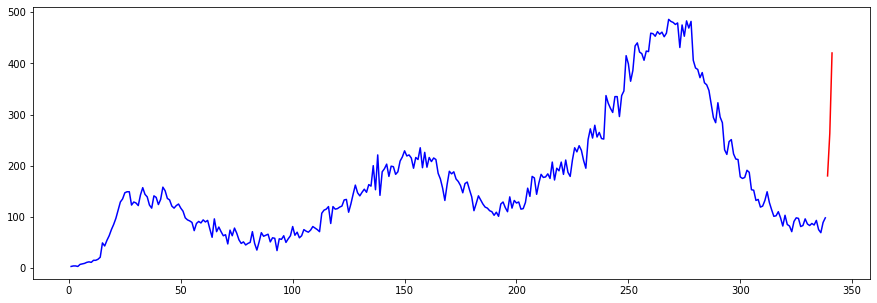

In [18]:
index_historical_data = numpy.arange(1, len(dataset)+1)     # Upper bound will be excluded
index_future_data = numpy.arange(len(dataset)+1, 342)       # Upper bound will be excluded. Reminder for myself: Lower bound is 339 (to set the Upper bound) 


#######
# Plot
#######
fig, ax = plt.subplots(figsize=(15,5))                      # Size of the figure

plt.plot(index_historical_data, 
         dataset, 
         color="blue")

plt.plot(index_future_data, 
         predictions_list, 
         color="red")

plt.show()